## TBATS time series forecasting

TBATS is an acronym for key features of the model:

T: Trigonometric seasonality

B: Box-Cox transformation (A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape)

A: ARIMA errors

T: Trend

S: Seasonal components

TBATS utilises exponential smoothing methods in its modelling where each seasonality is modelled by a trigonometric representation based on Fourier series.

To learn more about this model and the additional hyperparameters associated with this model, see [link](https://github.com/intive-DataScience/tbats)

Load in the required libraries and python modules

In [1]:
\l ml/ml.q
\l ml/init.q
\l ../utils.q

tbats:.p.import[`tbats]`:TBATS
plt:.p.import[`matplotlib.pyplot]

No shared object files for cutils.q, only q implementations available


A basic implementation of the TBATS model is shown below in the `Daily Temp` section, with a more complex implementation show in the `Bike Rental` section 

## Daily Temp

### Data Preperation

The below dataset contains the mimimum daily temperatures reached in Melbourne during the period from January 1981 - December 1990.

Any null values are deleted from the dataset.

In [2]:
show mintemp:`date`temp xcol ("PF";enlist",")0:`:../data/dailytemp.csv

// Delete any nulls from the data
mintemp:delete from mintemp where temp=0N

date                          temp
----------------------------------
1981.01.01D00:00:00.000000000 20.7
1981.01.02D00:00:00.000000000 17.9
1981.01.03D00:00:00.000000000 18.8
1981.01.04D00:00:00.000000000 14.6
1981.01.05D00:00:00.000000000 15.8
1981.01.06D00:00:00.000000000 15.8
1981.01.07D00:00:00.000000000 15.8
1981.01.08D00:00:00.000000000 17.4
1981.01.09D00:00:00.000000000 21.8
1981.01.10D00:00:00.000000000 20  
1981.01.11D00:00:00.000000000 16.2
1981.01.12D00:00:00.000000000 13.3
1981.01.13D00:00:00.000000000 16.7
1981.01.14D00:00:00.000000000 21.5
1981.01.15D00:00:00.000000000 25  
1981.01.16D00:00:00.000000000 20.7
1981.01.17D00:00:00.000000000 20.6
1981.01.18D00:00:00.000000000 24.8
1981.01.19D00:00:00.000000000 17.7
1981.01.20D00:00:00.000000000 15.5
..


The data is plotted below to portray the trends and cycles present in the dataset

/Users/dianeodonoghue/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


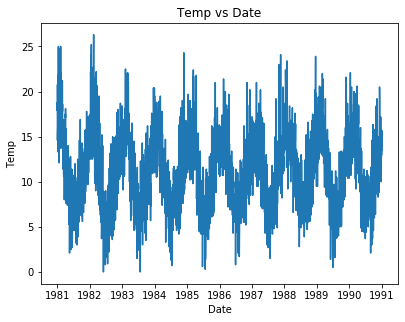

In [3]:
plttm[mintemp`date;mintemp`temp;"Temp"]

The missing datetimes in the dataset are included, back and forward filling is used to fill these gaps.

This was included as the TBATS model does not account for missing data, which may affect the model when trying to understand trends

In [4]:
mintemp:datefill[`date;mintemp;1D]

// Back and forward fill the missing data
mintemp:.ml.filltab[mintemp;();`date;::]

The data is then split into  a training and testing set (Making sure that no time leakage occurs). 

80% is chosen as train, 20% is testing data.

The dates are defined as the inputs and temperature as the target values

In [5]:
// Find the timestamp which splits the data 80/20
tts:ttstm[mintemp`date;mintemp`temp;.2]

// The data is then split into the training and testing sets
xtraintmp:tts`xtrain
ytraintmp:tts`ytrain
xtesttmp:tts`xtest
ytesttmp:tts`ytest

-1!"There is ",string[count xtraintmp]," datapoints in the training set"
-1!"There is ",string[count xtesttmp]," datapoints in the testing set"

"There is 2921 datapoints in the training set"


"There is 731 datapoints in the testing set"


### Model Training

The model only takes the predicted values as input, The different period lengths (i.e days of the week, years, etc) can be added as a hyperparameter called seasonal_periods

Hyper-parameters for this model include:

Parameter        | Explanation                              | Default
-----------------|------------------------------------------|----------------
use_box_cox      | Boolean indicating to use box_cox or not   | None (both cases shall be considered and better is selected by AIC)
box_cox_bounds   | Bounds associated if box_cox true          |(0, 1)
use_trend        | Add trend to the data                      | None (both cases shall be considered and better is selected by AIC)
use_damped_trend | Add damped trend to the data               | None (both cases shall be considered and better is selected by AIC)
seasonal_periods | Season periods, i.e days of the week, yearly  (7, 365.2) etc patterns seen | None
use_arma_errors  | Boolean indicatin got use arma errors      | True



**Note In order to make the models run faster, `use_box_cox pykw` and `use_damped_trend` was set to False, when set to positive, this model can take a considerably longer time to run**

Monthly and yearly trends are added to the model, with box_cox and and Arima set to False in order ot speed up the implementation

In [6]:
// Initialise the model, setting seasonal patterns
mdltmp:tbats[`seasonal_periods pykw (30,365.25);`use_box_cox pykw 0b;`use_arma_errors pykw 0b]

// Fit the model using the predicted values from the training set
\ts mdltmp:mdltmp[`:fit][ytraintmp]

130065 1664


### Model Forecast

The model is used to forecast future and calculate the root mean squared log error.

The `steps` attribute indicates how many time series future values to predict.

The root mean squared error is then calculated

In [7]:
// Forecast future values
predstmp:mdltmp[`:forecast][`steps pykw count xtesttmp]`

// Calculate the error
-1!"The Mean Squared Error is ",string .ml.mse[predstmp;ytesttmp]

"The Mean Squared Error is 15.15531"


The predicted and real values are also plotted to show how the models forecasted values varied from the true values

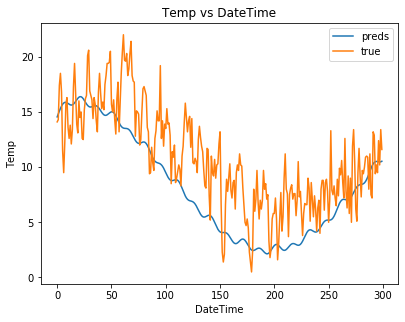

In [8]:
pltresult[300#predstmp;300#ytesttmp;"Temp"]

Above, the predicted values follow the same increasing and decreasing trend as the true values, however it does not correctly caluclate the exact values

## Bike Rentals

### Data Preperation

Load in the data

The dataset is a provided by TFL to predict future bike sales per hour. Additional data is also given in the form of seasonality and climate information such as season, indication of whether it is a holiday, temperature, wind_speed, current weather etc .

For the purpose of these notebook, when predictions are being made, it is assumed that these climate information will be available based off future weather predictions. 

In [9]:
show bikes:("PFFFFFFBFF";enlist ",")0:`:../data/london_merged.csv

timestamp                     cnt  t1  t2   hum  wind_speed weather_code is_h..
-----------------------------------------------------------------------------..
2015.01.04D00:00:00.000000000 182  3   2    93   6          3            0   ..
2015.01.04D01:00:00.000000000 138  3   2.5  93   5          1            0   ..
2015.01.04D02:00:00.000000000 134  2.5 2.5  96.5 0          1            0   ..
2015.01.04D03:00:00.000000000 72   2   2    100  0          1            0   ..
2015.01.04D04:00:00.000000000 47   2   0    93   6.5        1            0   ..
2015.01.04D05:00:00.000000000 46   2   2    93   4          1            0   ..
2015.01.04D06:00:00.000000000 51   1   -1   100  7          4            0   ..
2015.01.04D07:00:00.000000000 75   1   -1   100  7          4            0   ..
2015.01.04D08:00:00.000000000 131  1.5 -1   96.5 8          4            0   ..
2015.01.04D09:00:00.000000000 301  2   -0.5 100  9          3            0   ..
2015.01.04D10:00:00.000000000 528  3   -

The trends over time for the data is plotted below which shows that cyclical patterns are present in the dataset

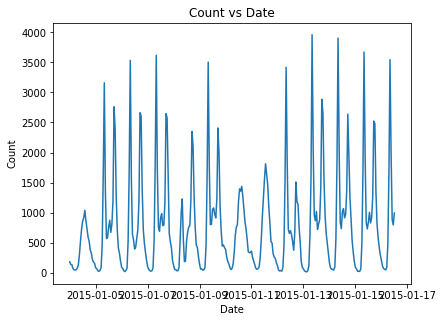

In [10]:
plttm[300#bikes`timestamp;300#bikes`cnt;"Count"]

The missing datetimes in the dataset are included, back and forward filling is used to fill these gaps.

This was included as the TBATS model does not account for missing data, which may affect the model when trying to understand trends

In [11]:
// Include any missing datetimes
bikes:datefill[`timestamp;bikes;01:00:00.000]

// Back and forward fill the missing data
bikes:.ml.filltab[bikes;();`timestamp;::]

The data is then split into  a training and testing set (Making sure that no time leakage occurs). 

80% is chosen as train, 20% is testing data.

In this scenario, the exogeneous columns are used as the input data, and bike count as the target data

In [12]:
// Find the timestamp which splits the data 80/20
tts:ttstm[delete cnt from bikes;bikes`cnt;0.2]

// The data is then split into the training and testing sets
xtrainbk:tts`xtrain
ytrainbk:tts`ytrain
xtestbk:tts`xtest
ytestbk:tts`ytest


-1!"There is ",string[count xtrainbk]," datapoints in the training set"
-1!"There is ",string[count xtestbk]," datapoints in the testing set"

"There is 14035 datapoints in the training set"


"There is 3509 datapoints in the testing set"


### Model Training

Exogenous variables are not allowed to be added to the model to improve forecasts, so the other columns in the dataset will be discarded

In [13]:
// Initialise the model, setting daily and weekly seasonal periods
mdlbk:tbats[`seasonal_periods pykw 24,(24*7);`use_box_cox pykw 0b;`use_arma_errors pykw 0b]

// Fit the model on the training target values
\ts mdlbk:mdlbk[`:fit][ytrainbk]

900084 1664


### Model Forecasting

The model is used to forecast future and calculate the root mean squared log error.

The `steps` attribute indicates how many time series future values to predict

In [14]:
// Forecast future values
predsbk:mdlbk[`:forecast][`steps pykw count xtestbk]`

// Calculate the error
-1!"The Root Mean Squared Log Error is ",string .ml.rmsle[predsbk;ytestbk]

"The Root Mean Squared Log Error is 1.101122"


The predicted and real values are also plotted to show how the models forecasted values varied from the true values

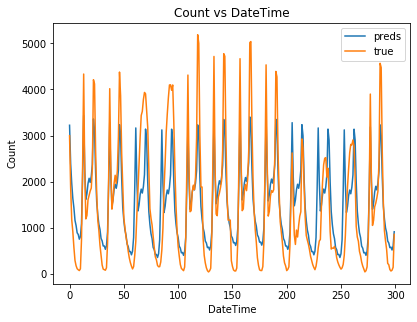

In [15]:
pltresult[300#predsbk;300#ytestbk;"Count"]

From the above plot, it is evident that the model was able to capture the general shape of the future values, forecasting the correct times for peaks and troughs, however it was not able to correctly calculate the associated values